# Verifying a mixed finite element solver for the incompressible Navier-Stokes-Boussinesq equations using FEniCS and the Method of Manufactured Solution.

This tutorial summarizes how to...
- solve the incompressible Navier-Stokes-Boussinesq [4] equations with mixed finite elements using FEniCS [1].
- write an extensible solver class using FEniCS.

and shows in more detail how to...
- verify a solver using the Method of Manufactured Solution (MMS) [2].
- compute empirical orders of convergence.

## Python packages

Show version info for the Python system running this notebook server.

In [1]:
import sys
print("Using Python " + sys.version)

Using Python 3.6.6 (default, Sep 12 2018, 18:26:19) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]


Use the FEniCS library to implement the solver and also for post-processing. We also import the back-end `dolfin` because there seems to be no other way to show the version number.

In [2]:
import fenics
import dolfin
print("Using fenics-" + dolfin.__version__)

Using fenics-2018.1.0


Typically FEniCS users don't directly use UFL; but we will need one feature to apply MMS with vector-valued solutions.

In [3]:
from ufl import unit_vector

We have to do a bit of arithmetic to compute the empirical order of convergence.

In [4]:
import math

Though `fenics` has the built-in `fenics.plot`, we will do some more advanced plotting.

In [5]:
import matplotlib
print("Using matplotlib-" + matplotlib.__version__)
%matplotlib inline

Using matplotlib-3.0.1


## The problem

Consider the strong form of the steady incompressible Navier-Stokes-Boussinesq equations, scaled for unit Reynolds number [4].

\begin{align*} 
    \nabla \cdot \mathbf{u} &= 0 \quad  \\
    \nabla\mathbf{u}\cdot\mathbf{u} + \nabla p - 2\mu \nabla \cdot \mathrm{sym}(\nabla\mathbf{u}) + \mathrm{RaPr}^{-1}T\hat{\mathbf{g}} &= 0 \quad \\
    \mathbf{u}\cdot\nabla T - \nabla \cdot \left(\mathrm{Pr}^{-1}\nabla T\right) &= 0
\end{align*}

Using mixed finite elements, we solve the stabilized* variational problem: 
Find $p, \mathbf{u}, T \in V \times \mathbf{V} \times V$ such that

\begin{align*}
    \mathcal{F} = 0 
    \quad \forall \psi_p, \boldsymbol{\psi}_u, \psi_T \in V \times \mathbf{V} \times V
\end{align*}

where

\begin{align*}
    \mathcal{F} = (\boldsymbol{\psi}_u, \nabla\mathbf{u}\cdot\mathbf{u} + \mathrm{RaPr}^{-1}T\hat{\mathbf{g}}) -(\nabla\cdot\boldsymbol{\psi}_u,p) + 2\mu(\mathrm{sym}(\nabla\boldsymbol{\psi}_u),\mathrm{sym}(\nabla\mathbf{u}))
    + (\psi_p,\nabla\cdot\mathbf{u} + \gamma p) + (\nabla \psi_T, \mathrm{Pr}^{-1}\nabla T - T\mathbf{u})
\end{align*}

We choose the Taylor-Hood [3] (i.e. P2P1) element, providing a piecewise quadratic space $\mathbf{V}$ and piecewise linear space $V$.

|Note| 
|----|
|We denote integrating inner products over the domain as $(v,u) = \int_\Omega v u d \mathbf{x}$ or $(\mathbf{v},\mathbf{u}) = \int_\Omega \mathbf{v} \cdot \mathbf{u} d \mathbf{x}$.|
|* The stability of this mixed method requires both P2P1 elements and the pressure penalty with factor $\gamma$.|

## The solver

The following class solves this variational problem for a general mesh, boundary conditions, and dynamic viscosity. The variational form is defined in its own method so that we can later easily extend it for verification via MMS. The focus of this tutorial is on MMS rather than the solver itself, so here we will skip over some details.

In [6]:
class NavierStokesBoussinesqSolver:
    
    def __init__(self, 
            mesh, boundary_condition_values, parameters):
        
        element = fenics.MixedElement([
            fenics.FiniteElement('P', mesh.ufl_cell(), 1),
            fenics.VectorElement('P', mesh.ufl_cell(), 2),
            fenics.FiniteElement('P', mesh.ufl_cell(), 1)])
        
        function_space = fenics.FunctionSpace(mesh, element)
        
        solution = fenics.Function(function_space)
        
        
        self.function_space = function_space
        
        self.solution = solution
        
        self.parameters = parameters
        
        
        boundary_conditions = [
            fenics.DirichletBC(
                function_space.sub(i),
                boundary_condition_values[i],
                "on_boundary")
            for i, g in enumerate(boundary_condition_values)]
        
        F = self.variational_form()
        
        problem = fenics.NonlinearVariationalProblem(
            F = F,
            u = solution,
            bcs = boundary_conditions,
            J = fenics.derivative(F, solution))
        
        fenics_solver = fenics.NonlinearVariationalSolver(problem)
        
        
        self.element = element
        
        self.fenics_solver = fenics_solver
        
        
        """ Patch: A scoping issue requires us to make bc's an attribute. """
        self.boundary_conditions = boundary_conditions
        
    def variational_form(self):
        
        mu = fenics.Constant(self.parameters["dynamic_viscosity"])
        
        Ra = fenics.Constant(self.parameters["rayleigh_number"])
        
        Pr = fenics.Constant(self.parameters["prandtl_number"])
        
        ghat = fenics.Constant((0., -1.))
        
        gamma = fenics.Constant(self.parameters["pressure_penalty_factor"])
        
        inner, dot, grad, div, sym = \
            fenics.inner, fenics.dot, fenics.grad, fenics.div, fenics.sym
        
        
        p, u, T = fenics.split(self.solution)
        
        psi_p, psi_u, psi_T = fenics.TestFunctions(self.function_space)
        
        mass = psi_p*div(u)
        
        momentum = dot(psi_u, dot(grad(u), u) + Ra/Pr*T*ghat) \
            - div(psi_u)*p + 2.*mu*inner(sym(grad(psi_u)), sym(grad(u)))
                    
        energy = dot(grad(psi_T), 1./Pr*grad(T) - T*u)
                    
        stabilization = psi_p*gamma*p
                    
        variational_form = (mass + momentum + energy + stabilization)*fenics.dx
        
        return variational_form
    
    def solve(self):
        
        self.fenics_solver.solve()

## Verification via MMS

So that we can verify the solver via the Method for Manufactured Solution (MMS) [2], we extend* the PDE (in stabilized penalty form) with arbitrary source terms.

\begin{align*} 
    \nabla \cdot \mathbf{u} + \gamma p&= s_p \quad  \\
    \nabla\mathbf{u}\cdot\mathbf{u} + \nabla p - 2\mu \nabla \cdot \mathrm{sym}(\nabla\mathbf{u}) + \mathrm{RaPr}^{-1}T\hat{\mathbf{g}} &= \mathbf{s}_u \quad \\
    \mathbf{u}\cdot\nabla T - \nabla \cdot \left(\mathrm{Pr}^{-1}\nabla T\right) &= s_T
\end{align*}


The extended variational form is then

\begin{align*}
    \mathcal{F} = (\boldsymbol{\psi}_u, \nabla\mathbf{u}\cdot\mathbf{u} + \mathrm{RaPr}^{-1}T\hat{\mathbf{g}} - \mathbf{s}_u) -(\nabla\cdot\boldsymbol{\psi}_u,p) + 2\mu(\mathrm{sym}(\nabla\boldsymbol{\psi}_u),\mathrm{sym}(\nabla\mathbf{u}))
    + (\psi_p,\nabla\cdot\mathbf{u} + \gamma p - s_p) + (\nabla \psi_T, \mathrm{Pr}^{-1}\nabla T - T\mathbf{u}) - \left(\psi_T, s_T\right)
\end{align*}

|Note| 
|----|
|* For many solvers, source terms already exist.|

Thanks to having already implemented an extensible solver class, we can implement these source terms with a few lines of code and without changing the original form.

In [7]:
class VerifiableSolver(NavierStokesBoussinesqSolver):
    
    def __init__(self, 
            mesh, boundary_condition_values, source_terms, parameters):
        
        self.source_terms = source_terms
        
        super().__init__(mesh, boundary_condition_values, parameters)
        
    def variational_form(self):
        
        F = super().variational_form()
        
        psi_p, psi_u, psi_T = fenics.TestFunctions(self.function_space)
        
        s_p, s_u, s_T = self.source_terms
        
        dot = fenics.dot
        
        F -= (psi_p*s_p + dot(psi_u, s_u) + psi_T*s_T)*fenics.dx
        
        return F

Manufacture a solution according to the guidelines in [3]. The syntax of `fenics` requires us to define this in terms of a mesh to access the spatial coordinates.

In [8]:
def manufactured_solution(mesh):
    
    sin, pi = fenics.sin, fenics.pi
    
    x, y = fenics.SpatialCoordinate(mesh)
    
    u_M = (sin(2.*pi*x)*sin(pi*y), sin(pi*x)*sin(2.*pi*y))
    
    p_M = -0.5*(u_M[0]**2 + u_M[1]**2)
    
    T_M = sin(2.*pi*x)*sin(pi*y)
    
    return p_M, u_M, T_M

Derive the source terms which will yield the manufactured solution
    by substituting the manufactured solution into the strong form.

In [9]:
def source_terms(manufactured_solution, parameters):
    
    grad, dot, div, sym = fenics.grad, fenics.dot, fenics.div, fenics.sym
    
    p, u, T = manufactured_solution
    
    mu = parameters["dynamic_viscosity"]
    
    Ra = parameters["rayleigh_number"]
    
    Pr = parameters["prandtl_number"]
    
    gamma = parameters["pressure_penalty_factor"]
    
    """ Working symbolically with the vector-valued solution in `fenics` 
    seems to require invocation of the cartesian unit vectors, 
    rather than using tuples or lists. """
    ihat, jhat = unit_vector(0, 2), unit_vector(1, 2)
    
    _u = u[0]*ihat + u[1]*jhat
    
    ghat = -jhat
    
    s_p = div(_u) + gamma*p
    
    s_u = grad(_u)*_u + grad(p) - 2.*div(mu*sym(grad(_u))) + Ra/Pr*T*ghat
    
    s_T = dot(_u, grad(T)) - 1./Pr*div(grad(T))
    
    return s_p, s_u, s_T

Compute the L2 norm error based on the manufactured solution and the computed discrete solution.

In [10]:
def L2_error(manufactured_solution, computed_solution):
    
    p_M, u_M, T_M = manufactured_solution
    
    ihat, jhat = unit_vector(0, 2), unit_vector(1, 2)
    
    _u_M = u_M[0]*ihat + u_M[1]*jhat
    
    p, u, T = computed_solution.split()
    
    return math.sqrt(fenics.assemble((
        (p - p_M)**2 + fenics.dot(u - _u_M, u - _u_M) + (T - T_M)**2
        )*fenics.dx))

Define a function for plotting the solution.

In [11]:
def plot(solution):
    
    p, u, T = fenics.split(solution)

    for var, label in zip(
            (p, u, u[0], u[1], T),
            ("$p$", "$\mathbf{u}$", "$u_0$", "$u_1$", "$T$")):

        colormap = fenics.plot(var)
        
        matplotlib.pyplot.colorbar(colormap)
        
        matplotlib.pyplot.title(label)
        
        matplotlib.pyplot.xlabel("$x$")
        
        matplotlib.pyplot.ylabel("$y$")
        
        matplotlib.pyplot.show()

Solve a series of problems with larger grids to verify the convergence order. Plot the L2 errors against the cell edge lengths with a log-log scale. Also print the computed empircal convergence order. We expect to see quadratic convergence.

|Note| 
|----|
|The minimum error will be on the order of $\gamma$, i.e. the stabilized method is not exactly consistent.|

In [12]:
def run_convergence_study(
        grid_sizes = (1, 2, 4, 8, 16, 32, 64),
        parameters = {
            "dynamic_viscosity": 0.1, 
            "rayleigh_number": 10., 
            "prandtl_number": 0.7,
            "pressure_penalty_factor": 1.e-7}):
    
    L2_errors = []

    for M in grid_sizes:

        mesh = fenics.UnitSquareMesh(M, M)
        
        """ We should be able to set the boundary values to the
        manufactured solution; but `fenics.DirichletBC` doesn't work
        as expected with a function space from `fenics.MixedElement`.
        For now we manufactured a solution with vanishing boundary values."""
        boundary_condition_values = (0., (0., 0.), 0.)
        
        solver = VerifiableSolver(
            mesh = mesh,
            boundary_condition_values = boundary_condition_values,
            source_terms = source_terms(
                manufactured_solution(mesh), 
                parameters),
            parameters = parameters)

        solver.solve()

        plot(solver.solution)

        L2_errors.append(L2_error(manufactured_solution(mesh), solver.solution))
        
    edge_lengths = [1./float(M) for M in grid_sizes]
    
    matplotlib.pyplot.loglog(edge_lengths, L2_errors)
    
    matplotlib.pyplot.xlabel("$h$")
    
    matplotlib.pyplot.ylabel("$L^2$ error")
    
    matplotlib.pyplot.axis("square")
    
    e, h = L2_errors, edge_lengths
    
    log = math.log
    
    orders = [(log(e[i + 1]) - log(e[i]))/(log(h[i + 1]) - log(h[i]))
              for i in range(len(e) - 1)]
    
    print("Convergence orders = " + str(orders))

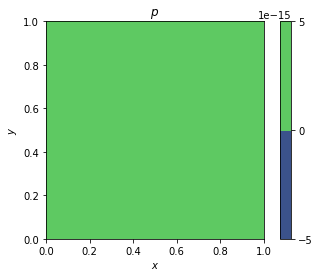

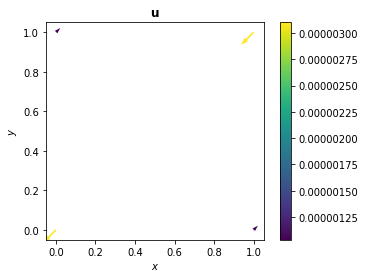

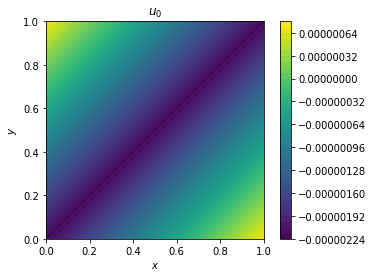

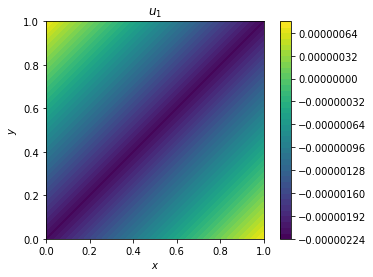

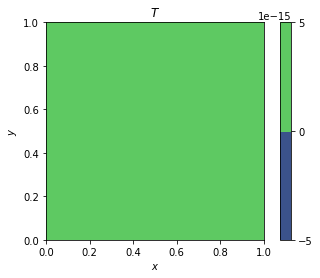

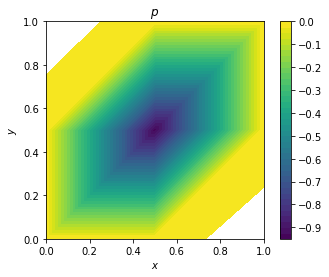

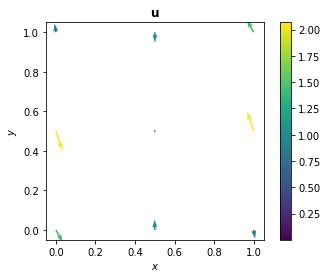

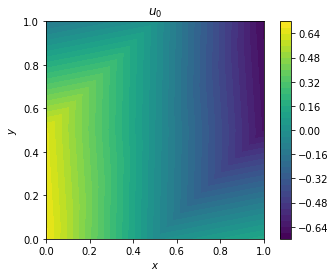

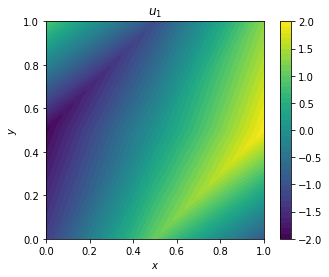

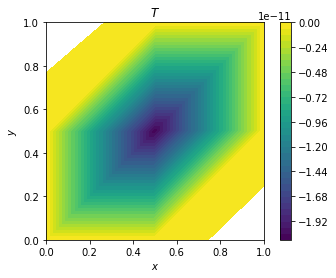

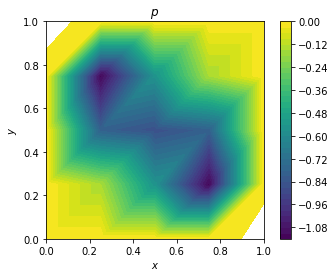

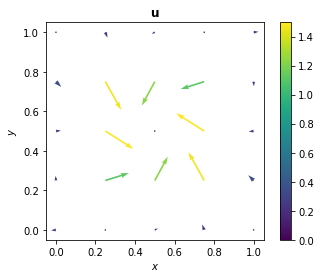

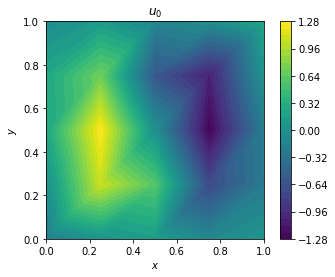

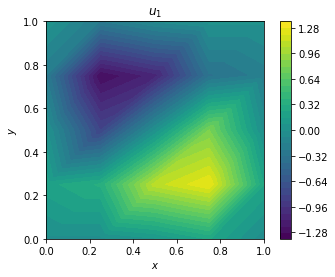

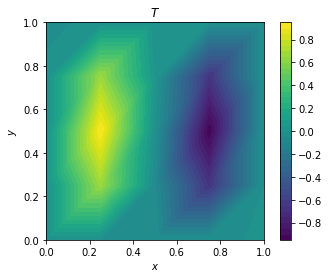

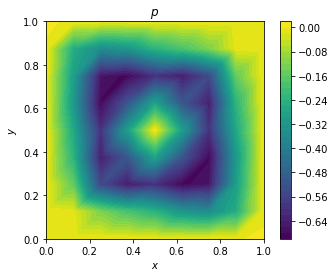

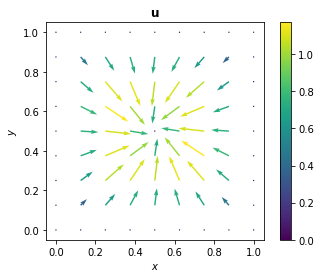

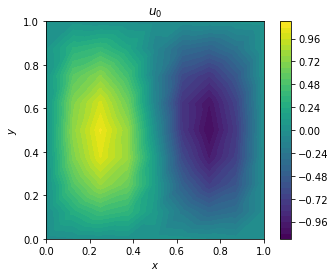

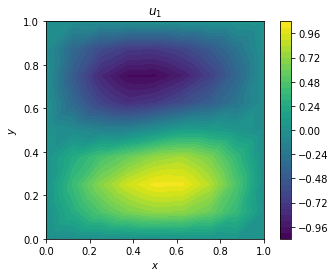

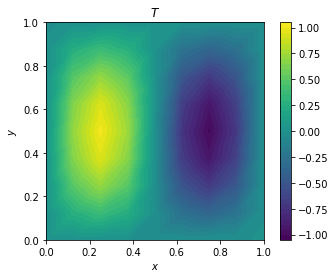

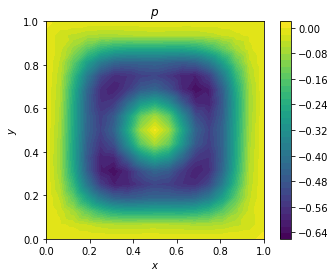

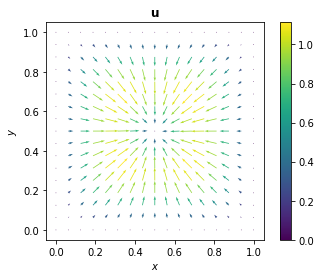

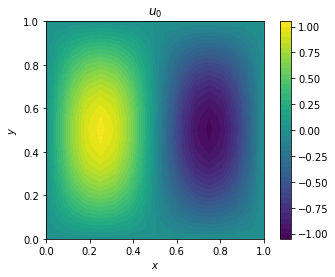

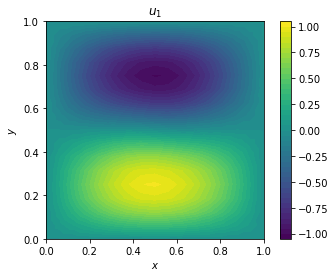

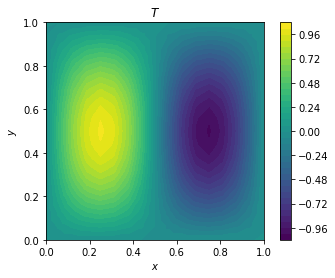

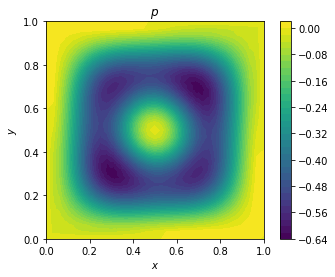

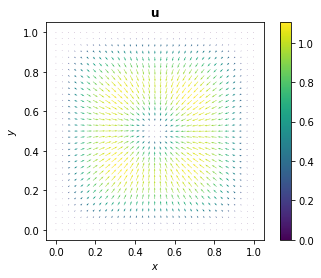

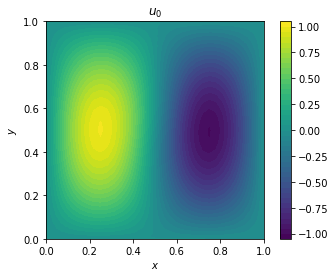

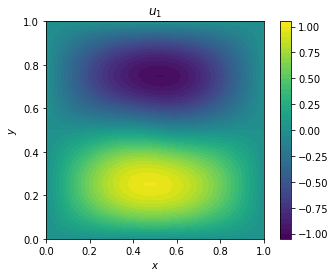

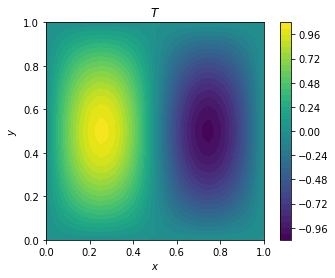

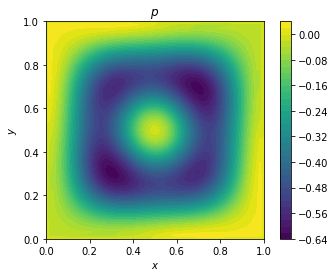

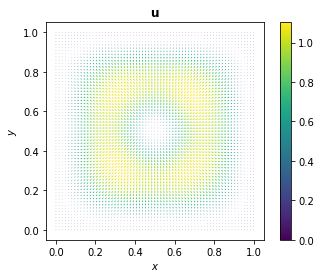

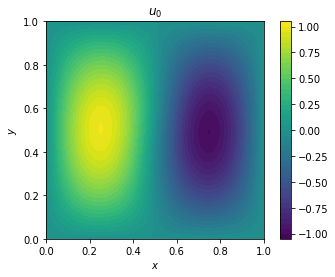

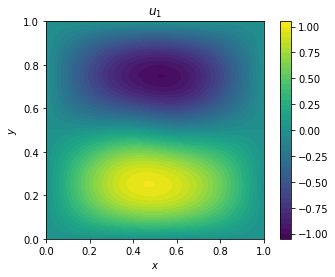

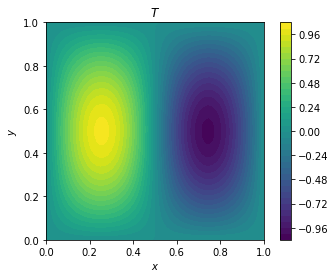

Convergence orders = [-0.48005238032985525, 1.46422843653645, 2.1332482415210694, 2.352646241549321, -0.8115468841790139, -0.23038238962047233]


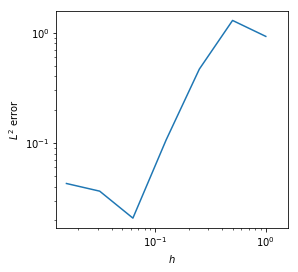

In [13]:
run_convergence_study()

## References
[1] A Logg, KA Mardal, and GN Wells. **Automated Solution of Differential Equations by the Finite Element Method**, *Springer*, 2012.

[2] K Salari and P Knupp. **Code verification by the method of manufactured solutions.**, *Sandia National Labs*, No. SAND2000-1444, 2000.

[3] J Donea and A Huerta. **Finite element methods for flow problems.** *John Wiley & Sons*, 2003. 

[4] I Danaila, R Moglan, F Hecht, and S Le Masson. **A newton method with adaptive finite elements for solving phase-change problems with natural convection.** *Journal of Computational Physics*, 274:826–840, 2014.